<a href="https://colab.research.google.com/github/DrAlexSanz/RNN-w1/blob/master/First_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Recurrent Neural Networks (RNN) are very effective for Natural Language Processing and other sequence tasks because they have "memory". They can read inputs $x^{\langle t \rangle}$ (such as words) one at a time, and remember some information/context through the hidden layer activations that get passed from one time-step to the next. This allows a uni-directional RNN to take information from the past to process later inputs. A bidirection RNN can take context from both the past and the future.

Notation:

* Superscript $[l]$ denotes an object associated with the $l^{th}$ layer.

  * Example: $a^{[4]}$ is the $4^{th}$ layer activation. $W^{[5]}$ and $b^{[5]}$ are the $5^{th}$ layer parameters.
* Superscript $(i)$ denotes an object associated with the $i^{th}$ example.

  * Example: $x^{(i)}$ is the $i^{th}$ training example input.
* Superscript $\langle t \rangle$ denotes an object at the $t^{th}$ time-step.

  * Example: $x^{\langle t \rangle}$ is the input x at the $t^{th}$ time-step. $x^{(i)\langle t \rangle}$ is the input at the $t^{th}$ timestep of example $i$.
* Lowerscript $i$ denotes the $i^{th}$ entry of a vector.

  * Example: $a^{[l]}_i$ denotes the $i^{th}$ entry of the activations in layer $l$.

In [10]:
%cd "/content"
!rm -rf RNN-w1

!git clone https://github.com/DrAlexSanz/RNN-w1.git
  
%cd "/content/RNN-w1"

/content
Cloning into 'RNN-w1'...
remote: Enumerating objects: 57, done.
remote: Counting objects: 100% (57/57), done.
remote: Compressing objects: 100% (53/53), done.
remote: Total 57 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (57/57), done.
/content/RNN-w1


In [0]:
import os
import sys
import scipy.io
import scipy.misc
import imageio
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
import numpy as np
import tensorflow as tf
from rnn_utils import *

# %matplotlib inline

# 1 - Forward propagation for the basic Recurrent Neural Network
The basic RNN has the structure below. In this example, $T_x = T_y$.

Here's how you can implement an RNN:

Steps:

* Implement the calculations needed for one time-step of the RNN.
* Implement a loop over $T_x$ time-steps in order to process all the inputs, one at a time.

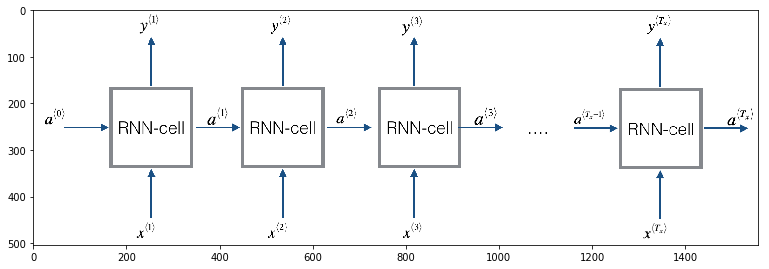

In [12]:
RNN = imageio.imread("images/RNN.png")
plt.figure(figsize = (13,10))
plt.imshow(RNN)

## 1.1 - RNN cell
A Recurrent neural network can be seen as the repetition of a single cell. You are first going to implement the computations for a single time-step. The following figure describes the operations for a single time-step of an RNN cell.

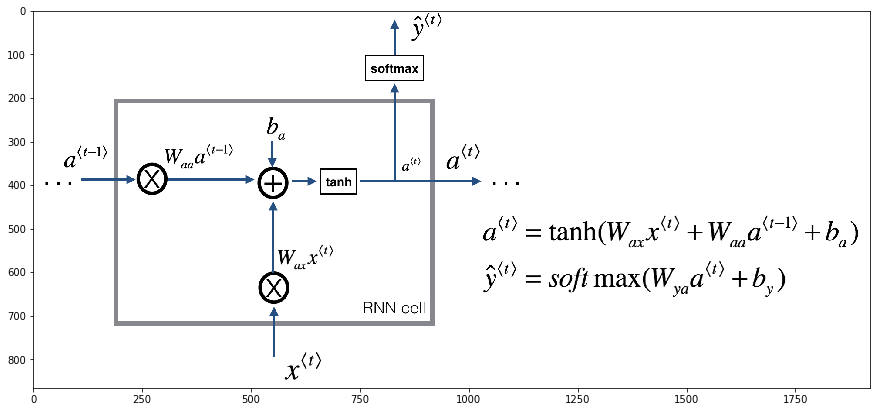

In [13]:
RNN_cell = imageio.imread("images/rnn_step_forward.png")
plt.figure(figsize = (15,13))
plt.imshow(RNN_cell)

In [0]:
def rnn_cell_forward(xt, a_prev, param):
    """
    This function implements a forward pass on ONE RNN cell, as shown above.
    
    inputs: aprev is a(t-1), shape (n_a, m), m is the examples batch.
            xt is the current input, shape (n_x, m)
            param is a python dictionary (from the utils file) that contains:
                  Wax: weights multiplying the current input, shape (n_a, n_x)
                  Waa: weights multiplying the hidden state, shape (n_a, n_a)
                  Wya: weights multiplying the hidden state to get the output, shape (n_y, n_a)
                  ba: Bias, shape (n_a, 1)
                  by: Bias relating the hidden state and the output, shape (n_y, 1)
    
    outputs: a_next is the next hidden state. Shape (n_a, m)
             yt_pred: prediction for the next timestep. Shape (ny_m)
             cache: values for backprop. It's (a_next, a_prev, xt, param)
    
    """
    
    # First things first. Let's load the parameters
    
    Wax = param["Wax"]
    Waa = param["Waa"]
    Wya = param["Wya"]
    ba = param["ba"]
    by = param["by"]
    
    # Compute the next activation state, see equation above
    
    a_next = np.tanh(np.dot(Wax, xt) + np.dot(Waa, a_prev) + ba) # Can be done only looking at the dimensions
    
    # Compute the output (after the softmax)
    
    yt_pred = softmax(np.dot(Wya, a_next) + by)
    
    cache = (a_next, a_prev, xt, param)
    
    return a_next, yt_pred, cache
    
    

In [15]:
np.random.seed(1)

xt = np.random.randn(3, 10)
a_prev = np.random.randn(5, 10)
Waa = np.random.randn(5, 5)
Wax = np.random.randn(5, 3)
Wya = np.random.randn(2, 5)
ba = np.random.randn(5, 1)
by = np.random.randn(2, 1)

parameters = {"Waa": Waa,
              "Wax": Wax,
              "Wya": Wya,
              "ba": ba,
              "by": by}

a_next, y_pred, cache = rnn_cell_forward(xt, a_prev, parameters)

print("a_next[4] = " + str(a_next[4]))
print("a_next shape is: " + str(a_next.shape))
print("Y_pred[1] = " + str(y_pred[1]))
print("Y_pred shape is: " + str(y_pred.shape))

a_next[4] = [ 0.59584544  0.18141802  0.61311866  0.99808218  0.85016201  0.99980978
 -0.18887155  0.99815551  0.6531151   0.82872037]
a_next shape is: (5, 10)
Y_pred[1] = [0.9888161  0.01682021 0.21140899 0.36817467 0.98988387 0.88945212
 0.36920224 0.9966312  0.9982559  0.17746526]
Y_pred shape is: (2, 10)


Wow this looked way more scary at the beginning. Let's do a full forward pass. It is actually "just" a for loop around this previous function. The next function implements the following picture, which is the same cell repeated several times.

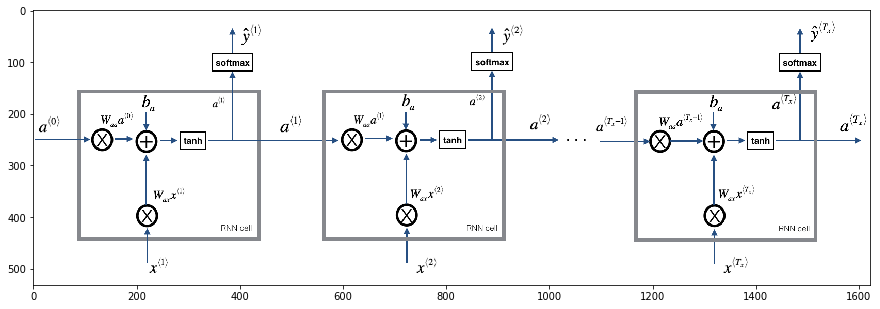

In [17]:
RNN_forward = imageio.imread("images/rnn1.png")
plt.figure(figsize = (15,13))
plt.imshow(RNN_forward)

In [0]:
def forward_pass(x, a0, param):
    """
    This function repeats the cell computation from the function above several times, to actually implement the forward pass of my RNN
    It also returns the caches for the backprop later.
    
    Inputs: x, is the input for the first cell. Shape (n_x, m, T_x), where T_x is the number of steps.
            a0 is the initial hidden state. Shape (n_a, m)
            param is the dictionary, as before
            
    Outputs: a is an array of hidden states, one element for each timestep. Shape (n_a, m, T_x)
            y_pred is the prediction array. Shape (n_y, m, T_x)
            caches: is the caches vector. Shape ((list of caches), x)
    """
    
    # Again, first thing, retrieve dimensions of different elements
    
    n_x, m, T_x = x.shape
    n_y, n_a = param["Wya"].shape
    
    # Initialize the caches list
    
    caches = []
    
    # Since y_pred and a are vectors, I can't use the empty list approach. I need to initialize with 0 and then access the relevant element each time
    
    a = np.zeros((n_a, m, T_x))
    y_pred = np.zeros((n_y, m, T_x))
    
    a_next = a0
    
    # Now the real computation
    
    for step in range(T_x):
        
        a_next, yt_pred, cache = rnn_cell_forward(x[:, :, step], a_next, param) # notice I index vector x, not a list!!!
        
        # Save a_next and y in the corresponding arrays
        a[:, :, step] = a_next
        y_pred[:, :, step] = yt_pred
        
        # Append the cache
        caches.append(cache)
    
    
    caches = (caches, x)
    
    return a, y_pred, caches

In [19]:
np.random.seed(1)

x = np.random.randn(3, 10, 4)
a0 = np.random.randn(5, 10)
Waa = np.random.randn(5, 5)
Wax = np.random.randn(5, 3)
Wya = np.random.randn(2, 5)
ba = np.random.randn(5, 1)
by = np.random.randn(2, 1)
parameters = {"Waa": Waa,
              "Wax": Wax,
              "Wya": Wya,
              "ba": ba,
              "by": by}

a, y_pred, caches = forward_pass(x, a0, parameters)

print("a[4][1] = " + str(a[4][1]))
print("a.shape = " + str(a.shape))
print("y_pred[1][3] = " + str(y_pred[1][3]))
print("y_pred.shape = " + str(y_pred.shape))
print("caches[1][1][3] = " + str(caches[1][1][3]))
print("Length of caches = " + str(len(caches)))

a[4][1] = [-0.99999375  0.77911235 -0.99861469 -0.99833267]
a.shape = (5, 10, 4)
y_pred[1][3] = [0.79560373 0.86224861 0.11118257 0.81515947]
y_pred.shape = (2, 10, 4)
caches[1][1][3] = [-1.1425182  -0.34934272 -0.20889423  0.58662319]
Length of caches = 2


Ah, the dimensions are so tricky!!!! But writing it down helps a lot. As Juan Ángel would say, ¡PÍNTALO, NIÑO!

In [16]:
print("Cipote")

Cipote
